In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/optima.dat', sep='\t')

# Remove missing values, i.e. choice = -1
data = data[data['Choice'] != -1]

In [3]:
# display every column of the dataframe
pd.set_option('display.max_columns', None)
data

,ID,DestAct,NbTransf,TimePT,WalkingTimePT,WaitingTimePT,CostPT,CostCar,TimeCar,NbHousehold,NbChild,NbCar,NbMoto,NbBicy,NbBicyChild,NbComp,NbTV,Internet,NewsPaperSubs,NbCellPhones,NbSmartPhone,HouseType,OwnHouse,NbRoomsHouse,YearsInHouse,Income,Gender,BirthYear,Mothertongue,FamilSitu,OccupStat,SocioProfCat,CalculatedIncome,Education,HalfFareST,LineRelST,GenAbST,AreaRelST,OtherST,CarAvail,MarginalCostPT,CostCarCHF,Envir01,Envir02,Envir03,Envir04,Envir05,Envir06,Mobil01,Mobil02,Mobil03,Mobil04,Mobil05,Mobil06,Mobil07,Mobil08,Mobil09,Mobil10,Mobil11,Mobil12,Mobil13,Mobil14,Mobil15,Mobil16,Mobil17,Mobil18,Mobil19,Mobil20,Mobil21,Mobil22,Mobil23,Mobil24,Mobil25,Mobil26,Mobil27,ResidCh01,ResidCh02,ResidCh03,ResidCh04,ResidCh05,ResidCh06,ResidCh07,LifSty01,LifSty02,LifSty03,LifSty04,LifSty05,LifSty06,LifSty07,LifSty08,LifSty09,LifSty10,LifSty11,LifSty12,LifSty13,LifSty14,TripPurpose,TypeCommune,UrbRur,LangCode,ClassifCodeLine,frequency,ResidChild,NbTrajects,FreqCarPar,FreqTrainPar,FreqOtherPar,FreqTripHouseh,Region,distance_km,Choice,InVehicleTime,ModeToSchool,ReportedDuration,CoderegionCAR,age,Weight
0,10350017,2,4,85,23,10,12.4,3.17,32,2,0,1,0,3,0,2,1,1,2,2,2,1,2,5.0,1,4,1,1983,2,2,3,3,7000,7,2,2,1,2,2,2,0.0,4.54,3,5,1,3,5,5,5,3,4,5,3,1,1,1,5,6,5,1,5,1,5,1,5,5,5,1,5,1,5,5,5,5,5,3,5,1,1,1,1,5,4,3,5,5,6,5,1,5,1,2,3,5,5,1,1,7,1,1,4,1,5,2,4,1,1,4,1,30.0,1,52,3,255,1,27,0.000379
2,10350025,11,2,82,33,5,3.0,0.45,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,2,2,-1,3.0,0.64,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,3,7,1,1,4,1,-1,1,-1,-1,-1,2,1,4.5,0,44,-1,20,1,-1,0.000368
3,10350075,1,3,107,21,31,24.0,2.36,23,2,0,1,0,0,0,1,2,1,1,2,0,1,1,5.0,29,2,2,1947,2,2,2,4,3250,3,2,2,2,2,2,1,24.0,3.38,3,2,3,4,4,4,4,4,3,5,3,4,4,3,5,2,4,2,5,5,4,3,4,5,4,1,4,4,4,2,4,2,4,4,4,4,3,3,4,5,4,2,4,4,3,3,3,4,3,2,4,4,4,2,1,7,1,1,4,1,5,1,3,2,2,1,1,25.0,1,55,-1,30,1,63,0.000368
4,10350085,1,5,190,116,18,10.8,1.16,14,3,0,2,0,3,0,1,2,1,2,2,0,1,1,4.0,22,4,1,1953,2,3,1,6,7000,3,2,2,2,2,2,1,10.8,1.66,1,3,3,3,5,4,5,1,3,4,4,5,5,1,2,4,5,1,5,5,3,5,4,6,6,6,5,1,5,3,1,6,1,3,3,2,2,1,3,3,3,4,3,3,1,3,1,1,3,3,3,3,4,1,1,7,1,1,4,1,6,2,2,1,2,3,1,12.5,1,56,-1,20,1,57,0.000409
5,10350086,1,4,116,38,29,9.6,1.89,20,3,0,2,0,3,0,1,2,1,2,3,0,1,1,4.0,22,4,2,1952,2,3,4,6,7000,3,2,2,2,2,2,2,9.6,2.71,2,4,3,2,5,4,4,2,3,4,3,5,2,1,3,3,5,2,5,4,3,5,3,3,3,2,4,1,2,2,2,2,2,3,3,4,2,1,2,5,4,4,4,3,1,2,2,4,3,4,2,2,1,2,1,7,1,1,4,1,5,2,1,2,2,3,1,19.0,1,49,-1,30,1,58,0.000368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,1,4,148,28,69,10.4,3.92,40,5,2,1,1,4,2,1,1,1,1,2,0,1,2,7.0,16,2,2,1973,1,3,2,8,3250,3,2,2,2,2,2,1,10.4,5.62,3,4,4,3,3,3,3,3,3,3,3,5,5,3,4,4,4,4,5,5,3,3,3,3,3,3,4,4,4,4,3,3,3,4,3,3,3,3,3,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,8,1,2,3,2,5,1,1,1,1,3,7,42.0,1,51,5,35,7,37,0.000870
2261,96040537,8,0,139,116,0,14.4,3.18,43,5,0,2,1,1,0,2,1,1,2,5,0,1,1,7.0,23,4,2,1964,1,3,1,3,7000,3,2,2,2,2,2,1,14.4,4.56,2,3,4,6,6,4,4,6,4,6,6,5,5,2,6,6,5,2,5,6,6,4,4,3,3,3,6,2,4,6,2,6,6,1,1,2,3,1,1,5,2,2,4,5,5,2,1,5,3,1,2,4,2,4,-1,8,1,2,3,2,6,4,4,1,1,3,7,32.0,1,23,5,70,7,46,0.000368
2262,96040537,8,0,71,57,0,6.0,0.94,12,5,0,2,1,1,0,2,1,1,2,5,0,1,1,7.0,23,4,2,1964,1,3,1,3,7000,3,2,2,2,2,2,1,6.0,1.35,2,3,4,6,6,4,4,6,4,6,6,5,5,2,6,6,5,2,5,6,6,4,4,3,3,3,6,2,4,6,2,6,6,1,1,2,3,1,1,5,2,2,4,5,5,2,1,5,3,1,2,4,2,4,3,8,1,2,3,2,6,2,4,1,1,3,7,9.0,1,14,5,20,7,46,0.000368
2263,96040538,11,2,118,70,10,11.4,1.77,24,5,0,2,1,1,0,2,1,1,2,5,0,1,1

In [4]:
data_used = data[['ID', 'TimePT', 'WalkingTimePT', 'WaitingTimePT', 'MarginalCostPT', 'TimeCar',
                   'CostCarCHF', 'ReportedDuration', 'Choice']]

In [5]:
data_used

,ID,TimePT,WalkingTimePT,WaitingTimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice
0,10350017,85,23,10,0.0,32,4.54,255,1
2,10350025,82,33,5,3.0,6,0.64,20,0
3,10350075,107,21,31,24.0,23,3.38,30,1
4,10350085,190,116,18,10.8,14,1.66,20,1
5,10350086,116,38,29,9.6,20,2.71,30,1
...,...,...,...,...,...,...,...,...,...
2259,96040531,148,28,69,10.4,40,5.62,35,1
2261,96040537,139,116,0,14.4,43,4.56,70,1
2262,96040537,71,57,0,6.0,12,1.35,20,1
2263,96040538,118,70,10,11.4,24,2.54,30,1


In [6]:
# beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_private_soft"]


# Define log-likelihood function
def log_likelihood_optima_NLM(beta, data):
    # Define utility functions
    data['U_PT'] = beta[2] * (data['TimePT'] + data['WalkingTimePT'] + data['WaitingTimePT']) + \
                    beta[3] * data['MarginalCostPT']
    data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
    data['U_soft'] = beta[1] + beta[2] * data['ReportedDuration']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_private_soft'] = np.log(np.exp(data['U_private'] / beta[4]) + np.exp(data['U_soft'] / beta[4]))
    
    # Nest probabilities
    data['P_nest_private_soft'] = np.exp(beta[4] * data['logsum_private_soft']) / \
                               (np.exp(beta[4] * data['logsum_private_soft']) + np.exp(data['U_PT']))
    data['P_nest_PT'] = 1 - data['P_nest_private_soft']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_private_in_private_soft'] = (np.exp(data['U_private'] / beta[4])) / \
                                  (np.exp(data['U_private'] / beta[4]) + np.exp(data['U_soft'] / beta[4]))
    data['P_soft_in_private_soft'] = 1 - data['P_private_in_private_soft']
    
    # Full probabilities
    data['P_PT_1'] = data['P_nest_PT']
    data['P_private_2'] = data['P_nest_private_soft'] * data['P_private_in_private_soft']
    data['P_soft_3'] = data['P_nest_private_soft'] * data['P_soft_in_private_soft']

    # Calculate probability for chosen alternative for each row
    data['P'] = (data['Choice'] == 0) * data['P_PT_1'] + \
                (data['Choice'] == 1) * data['P_private_2'] + \
                (data['Choice'] == 2) * data['P_soft_3']
    
    # Calculate log-likelihood
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood


In [7]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 1])
beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_soft"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_optima_NLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1973536077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * (data['TimePT'] + data['WalkingTimePT'] + data['WaitingTimePT']) + \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1973536077.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1973536077

Optimization Results:
        Parameter    Estimate  Robust Asymptotic SE   t-statistic  \
0     ASC_private   -9.933417              0.071855   -138.242426   
1        ASC_soft -355.175161              0.011858 -29951.403366   
2       BETA_Time   -0.003137              0.000580     -5.412585   
3       BETA_Cost   -0.071954              0.006223    -11.562038   
4  lambda_PT_soft  135.801186              0.029021   4679.394058   

        p-value  
0  0.000000e+00  
1  0.000000e+00  
2  6.999010e-08  
3  0.000000e+00  
4  0.000000e+00  
AIC: 2862.373341370198
BIC: 2890.137151791269
Log-likelihood: -1426.186670685099


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1973536077.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['P_private_in_private_soft'] = (np.exp(data['U_private'] / beta[4])) / \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1973536077.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['P_soft_in_private_soft'] = 1 - data['P_private_in_private_soft']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1973536077.py:26: SettingWithCopyWarning

In [8]:
df_input = data[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF',
                                         'ReportedDuration']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/1679802737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [9]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [10]:
def simulate_choice_optima(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_PT_1', 'P_private_2', 'P_soft_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [11]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/2856924636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)


,ID,TimePT,WalkingTimePT,WaitingTimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice,U_PT,U_private,U_soft,logsum_private_soft,P_nest_private_soft,P_nest_PT,P_private_in_private_soft,P_soft_in_private_soft,P_PT_1,P_private_2,P_soft_3,P,simulated_choice
0,10350017,85,23,10,0.0,32,4.54,255,1,-0.370216,-10.360484,-355.975204,-0.000746,0.566834,0.433166,0.927237,0.072763,0.433166,0.525589,0.041244,0.525589,2
2,10350025,82,33,5,3.0,6,0.64,20,0,-0.592352,-9.998292,-355.237909,0.002123,0.706947,0.293053,0.927051,0.072949,0.293053,0.655375,0.051571,0.293053,1
3,10350075,107,21,31,24.0,23,3.38,30,1,-2.225738,-10.248781,-355.269284,0.000396,0.907164,0.092836,0.926941,0.073059,0.092836,0.840888,0.066276,0.840888,2
4,10350085,190,116,18,10.8,14,1.66,20,1,-1.793625,-10.096784,-355.237909,0.001450,0.879803,0.120197,0.927002,0.072998,0.120197,0.815579,0.064224,0.815579,2
5,10350086,116,38,29,9.6,20,2.71,30,1,-1.264904,-10.191160,-355.269284,0.000789,0.797715,0.202285,0.926970,0.073030,0.202285,0.739458,0.058257,0.739458,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,148,28,69,10.4,40,5.62,35,1,-1.516987,-10.463294,-355.284971,-0.001077,0.797504,0.202496,0.926842,0.073158,0.202496,0.739160,0.058344,0.739160,2
2261,96040537,139,116,0,14.4,43,4.56,70,1,-1.836176,-10.396435,-355.394781,-0.000680,0.851181,0.148819,0.926930,0.073070,0.148819,0.788986,0.062195,0.788986,2
2262,96040537,71,57,0,6.0,12,1.35,20,1,-0.833312,-10.068204,-355.237909,0.001645,0.742069,0.257931,0.927016,0.072984,0.257931,0.687910,0.054159,0.687910,2
2263,96040538,118,70,10,11.4,24,2.54,30,1,-1.441482,-10.191478,-355.269284,0.000787,0.824676,0.175324,0.926970,0.073030,0.175324,0.764450,0.060226,0.764450,2


Iteration: 1 out of 5000
Objective function value: 1.0985322561962754
Iteration: 2 out of 5000
Objective function value: 0.7945398305073719
Iteration: 3 out of 5000
Objective function value: 0.59918609970886
Iteration: 4 out of 5000
Objective function value: 0.4844786363479665
Iteration: 5 out of 5000
Objective function value: 0.4090347865069352
Iteration: 6 out of 5000
Objective function value: 0.35540199322338406
Iteration: 7 out of 5000
Objective function value: 0.31515775087830983
Iteration: 8 out of 5000
Objective function value: 0.28374694948807716
Iteration: 9 out of 5000
Objective function value: 0.2584866997722449
Iteration: 10 out of 5000
Objective function value: 0.23769071792379737
Iteration: 11 out of 5000
Objective function value: 0.22024378788797896
Iteration: 12 out of 5000
Objective function value: 0.2053776120451874
Iteration: 13 out of 5000
Objective function value: 0.1925448631958784
Iteration: 14 out of 5000
Objective function value: 0.18134457769628753
Iteration: 

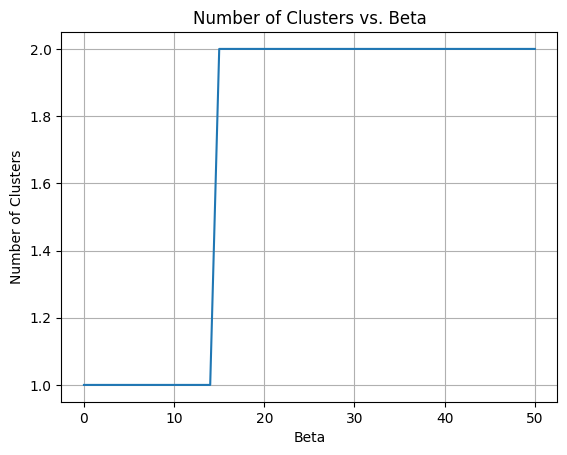

In [12]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [13]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=500, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Objective function value: 1.0791439042735531
Iteration: 2 out of 5000
Objective function value: -9.698377404127818
Iteration: 3 out of 5000
Objective function value: -15.92035972923269
Iteration: 4 out of 5000
Objective function value: -16.914567737520496
Iteration: 5 out of 5000
Objective function value: -17.164693141676665
Iteration: 6 out of 5000
Objective function value: -17.20869935955368
Iteration: 7 out of 5000
Objective function value: -17.22164454736216
Iteration: 8 out of 5000
Objective function value: -17.230570988463533
Iteration: 9 out of 5000
Objective function value: -17.248143384637945
Iteration: 10 out of 5000
Objective function value: -17.272638142937716
Iteration: 11 out of 5000
Objective function value: -17.31530877944269
Iteration: 12 out of 5000
Objective function value: -17.401335096208744
Iteration: 13 out of 5000
Objective function value: -17.519596086237218
Iteration: 14 out of 5000
Objective function value: -17.60952957696039
Iteratio

In [14]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [15]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'Choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
1    1386
2     454
0      66
Name: count, dtype: int64

 Choice     0    1    2
cluster               
0         54   11    1
1        429  847  110
2         53  398    3

 max_proba   1     2
cluster            
0          66     0
1          17  1369
2           0   454

 simulated_choice    1    2   3
cluster                       
0                  43   19   4
1                 443  875  68
2                  46  381  27


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/2352194042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14403/2352194042.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
